# AGE PREDICTION PROJECT

## Initialization

In [9]:
!unzip -o -q faces_dataset.zip

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
import os


## Load Data

In [11]:
base = 'faces_dataset'

df = pd.read_csv(f'{base}/labels.csv')
df['file_path'] = df['file_name'].apply(lambda f: os.path.join(base, 'final_files', f))
print(df.head())
df.info()

    file_name  real_age                             file_path
0  000000.jpg         4  faces_dataset/final_files/000000.jpg
1  000001.jpg        18  faces_dataset/final_files/000001.jpg
2  000002.jpg        80  faces_dataset/final_files/000002.jpg
3  000003.jpg        50  faces_dataset/final_files/000003.jpg
4  000004.jpg        17  faces_dataset/final_files/000004.jpg
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
 2   file_path  7591 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.0+ KB


## Exploratory Data Analysis

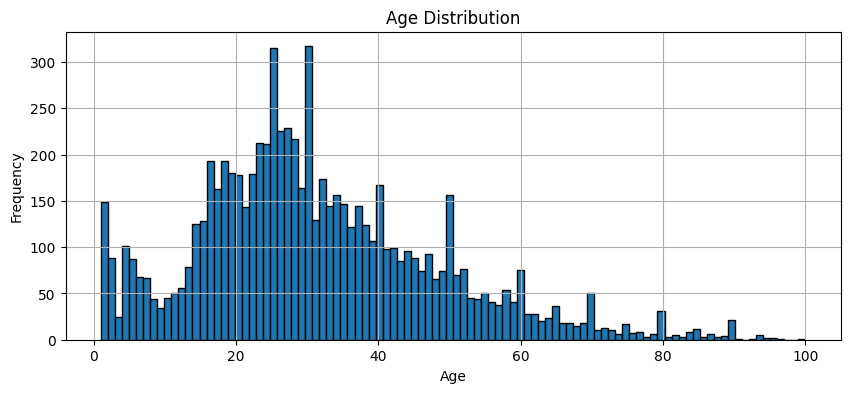

In [18]:
# Age distribution
plt.figure(figsize=(10,4))
df['real_age'].hist(bins=100, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


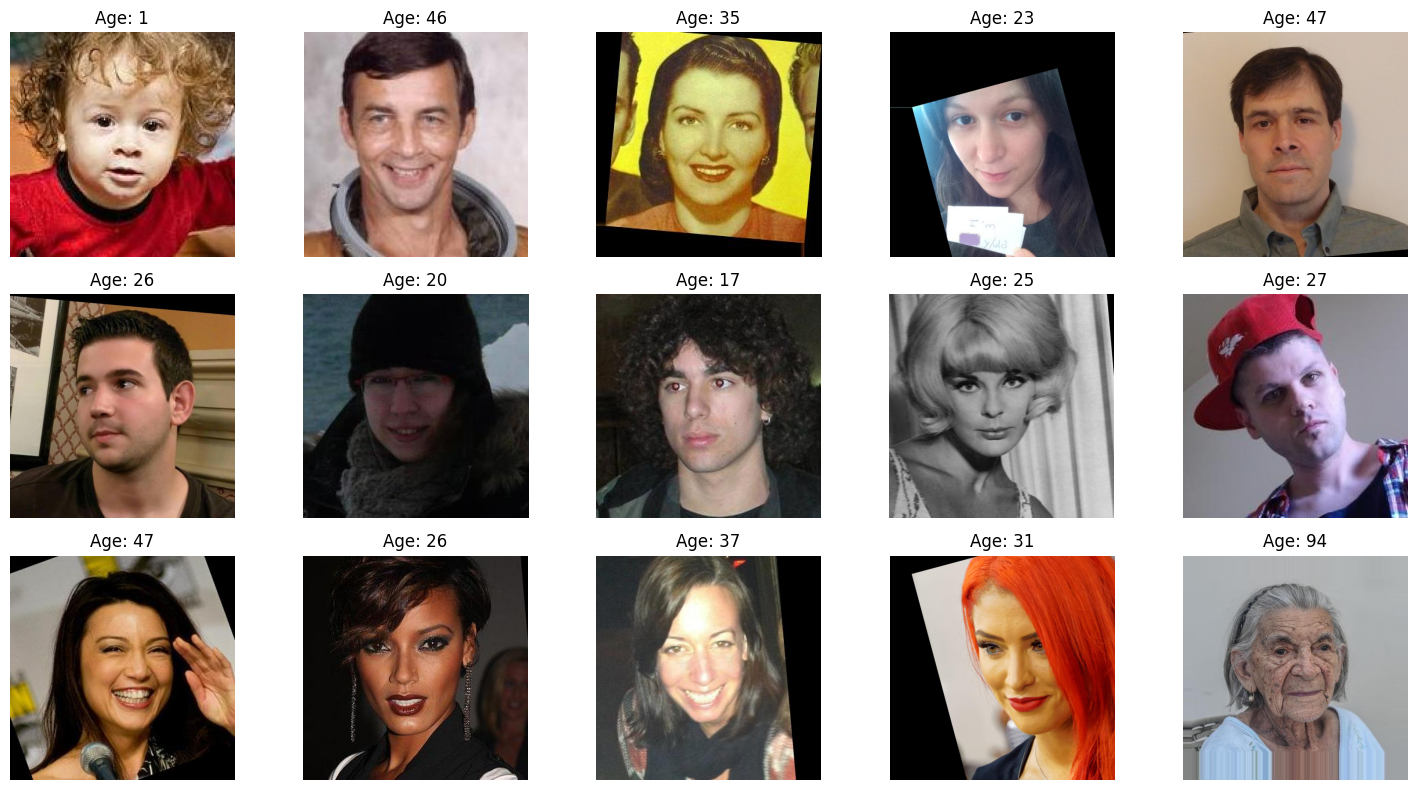

In [19]:
# Sample images
sample = df.sample(15, random_state=42)
plt.figure(figsize=(15,8))
for i, row in enumerate(sample.itertuples()):
    img = Image.open(row.file_path)
    plt.subplot(3,5,i+1)
    plt.imshow(img)
    plt.title(f"Age: {row.real_age}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Findings
* The dataset contains 7591 labeled faces with no duplicates or null
values.
* The histogram is not uniformly distributed.
* The age distribution is skewed, with most samples in the range 20-40 ages.
* There's a sharp peal around 25-30 year-0ld.

In [13]:
def load_dataframe(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    df['file_path'] = df['file_name'].apply(
        lambda x: os.path.join(path, 'final_files', x)
    )
    return df[df['file_path'].apply(os.path.exists)]

def get_data_generators(path, img_size=(64,64), batch_size=8, val_split=0.25):
    df = load_dataframe(path)
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split,
        horizontal_flip=True,
        rotation_range=10
    )
    train_gen = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name', y_col='real_age',
        target_size=img_size, batch_size=batch_size,
        class_mode='raw', subset='training', shuffle=True
    )
    val_gen = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name', y_col='real_age',
        target_size=img_size, batch_size=batch_size,
        class_mode='raw', subset='validation', shuffle=False
    )
    return train_gen, val_gen

## Instantiate & Train

In [14]:
def create_model(input_shape=(64,64,3)):
    inputs = Input(shape=input_shape)
    base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    x = GlobalAveragePooling2D()(base.output)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [15]:
train_gen, val_gen = get_data_generators('faces_dataset')

model = create_model(input_shape=(64,64,3))

callbacks = [
    EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_age_model.keras', monitor='val_mae', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=2
)


Found 5694 validated image filenames.
Found 1897 validated image filenames.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


712/712 - 121s - 170ms/step - loss: 284.7000 - mae: 13.0492 - val_loss: 300.3295 - val_mae: 13.0102
Epoch 2/50
712/712 - 38s - 54ms/step - loss: 230.0214 - mae: 11.6529 - val_loss: 237.3441 - val_mae: 12.4327
Epoch 3/50
712/712 - 39s - 54ms/step - loss: 207.3442 - mae: 11.1320 - val_loss: 205.5816 - val_mae: 11.0716
Epoch 4/50
712/712 - 41s - 57ms/step - loss: 194.1255 - mae: 10.7153 - val_loss: 215.2866 - val_mae: 10.9427
Epoch 5/50
712/712 - 37s - 52ms/step - loss: 192.7568 - mae: 10.7317 - val_loss: 190.4174 - val_mae: 10.7809
Epoch 6/50
712/712 - 38s - 53ms/step - loss: 177.0023 - mae: 10.2058 - val_loss: 175.8305 - val_mae: 10.5899
Epoch 7/50
712/712 - 37s - 51ms/step - loss: 167.2754 - mae: 9.9192 - val_loss: 192.5164 - val_mae: 10.8304
Epoch 8/50
712/712 - 37s - 51ms/step - loss: 163.9185 - mae: 9.8041 - val_loss: 191.2484 - val_mae: 10.9901
Epoch 9/50
712/712 - 37s - 52ms/step - loss: 159.7797 - mae: 9.6993 - val_loss: 177.6728 - val_mae: 10.1812
Epoch 10/50
712/712 - 39s - 55m

#

## Results

The CNN was trained on 5,694 images (with 1,897 held out for validation). It began with a training MAE of 13.05 years and a validation MAE of 13.01 years in epoch 1. As training progressed, the training MAE steadily fell to about 7.34 years by epoch 22, while the validation MAE reached its lowest point of 8.79 years around epoch 19 and then stabilized around 8.8–9.3 years. In sum, the model ultimately predicts age with an average error of roughly 8–9 years.


## Conclusion

In addition to the model’s performance (MAE ≈ 8–9 years), an inspection of our dataset’s age distribution shows a strong concentration of examples between roughly 15–35 years, with far fewer samples at the youngest (< 5) and oldest (> 65) extremes. This imbalance likely contributes to higher prediction errors at the tails.

## Next Steps

- Data Balancing: Collect or synthesize more images for under-represented age brackets (children and seniors) or apply class-weighted loss to mitigate this skew.

- Error Analysis by Age Group: Evaluate MAE within each bucket (e.g. 0–15, 15–35, 35–65, 65+) to quantify where the model under-performs.

- Augmentation Strategies: Introduce targeted augmentations (e.g. age-preserving style transfers) to enrich scarce age ranges.

- Robustness Testing: Validate on external datasets with a different age profile to ensure generalization across the full spectrum.

By addressing the dataset’s distributional biases alongside our existing evaluation and deployment pipeline, we can build a more accurate and fair age-prediction system.


